## Skills Illustrated
* **NLP**
    * Regular Expressions (RegEx)
    * Tokenization
* **Parallelization**
    * MapReduce

### Imports

In [229]:
# MR processing
from functools import reduce as reduce # python 3 does not have built-in 
from multiprocessing import Pool # for parallel processing

# NLP
import re # regular expressions
import string # simple string formatting 
from nltk import word_tokenize # tokenizer
from nltk.corpus import stopwords # token removal

# other
import requests # handling URLs
from collections import Counter # data structure
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

### Text Data

In [253]:
text_url = 'http://www.gutenberg.org/files/11/11-0.txt'
req = requests.get(text_url)
content = req.text
content[:100]

'\ufeffProject Gutenberg’s Alice’s Adventures in Wonderland, by Lewis Carroll\r\n\r\nThis eBook is for the use'

### Pre-Processing

In [121]:
# clip the start and end of the book
start_pat = '*** START OF THIS PROJECT GUTENBERG EBOOK ALICE’S ADVENTURES IN WONDERLAND ***'
end_pat = '*** END OF THIS PROJECT GUTENBERG EBOOK ALICE’S ADVENTURES IN WONDERLAND ***'

In [122]:
# finding where the text truly begins
start_i = content.index(start_pat) + len(start_pat)
end_i = content.index(end_pat) 
content = content[start_i:end_i]
content = content.lower()

In [124]:
# separating text by chapters
chapter_pat = 'chapter [ivx.]+[ ]*[\w -]*[\\r\\n]*'
chapters = re.split(chapter_pat, content)[1:]
n_chapters = len(chapters)
n_chapters

12

In [125]:
formatting_pat = '[(\r)(\n)]'

# were going to get rid of formatting characters (\r, \n)
# and tokenize each chapter, for processing later
chapters = [word_tokenize(re.sub(formatting_pat, ' ', chapter)) for chapter in chapters]

In [156]:
p = Pool(n_chapters)

In [157]:
# simple counter function, which will also remove some punctuation tokens
def count_terms(data):
    
    # list of punctuation characters we want to remove
    remove = list(string.punctuation) + ['--', "’"]
    
    # where we store our token counts
    c = Counter(data)
    
    # try to remove all punctuation characters
    for punct in remove:
        try:
            c.pop(punct)
        except:
            # we don't care if there is no occurence of a punctuation token
            pass  
    
    # return counts
    return c

### Map Phase

In [158]:
pooled_counts = p.map(count_terms, chapters)

In [160]:
# one for each chapter
len(pooled_counts)

12

### Reduce Phase

In [164]:
total_counts = reduce(lambda c1, c2: c1 + c2, pooled_counts)

### Results

In [166]:
# unique words
len(total_counts)

3064

In [167]:
# top 10 most used words
# not surprisingly, mostly stop words
total_counts.most_common(10)

[('the', 1609),
 ('and', 808),
 ('to', 719),
 ('a', 615),
 ('she', 537),
 ('of', 499),
 ('it', 489),
 ('said', 462),
 ('alice', 385),
 ('in', 357)]

In [171]:
# we could now choose to remove the stop words
# to make things a bit more interesting

sws = stopwords.words('english')

for sw in sws: 
    try: 
        total_counts.pop(sw)
    except:
        pass

In [173]:
len(total_counts)

2941

In [174]:
total_counts.most_common(10)

[('said', 462),
 ('alice', 385),
 ('little', 127),
 ('‘i', 126),
 ('one', 97),
 ('like', 83),
 ('went', 83),
 ('would', 78),
 ('know', 78),
 ('could', 77)]

### Visualization

In [251]:
# some data type forcing
top_10 = dict(total_counts.most_common(10))
xr = np.asarray(range(len(top_10)))
yr = np.asarray(list(top_10.values()))
yr = yr / sum(total_counts.values())
lab = np.asarray(list(top_10.keys()))

# using numpy's argsort
sort_i = np.argsort(yr)[::-1]
yr = yr[sort_i]
lab = lab[sort_i]

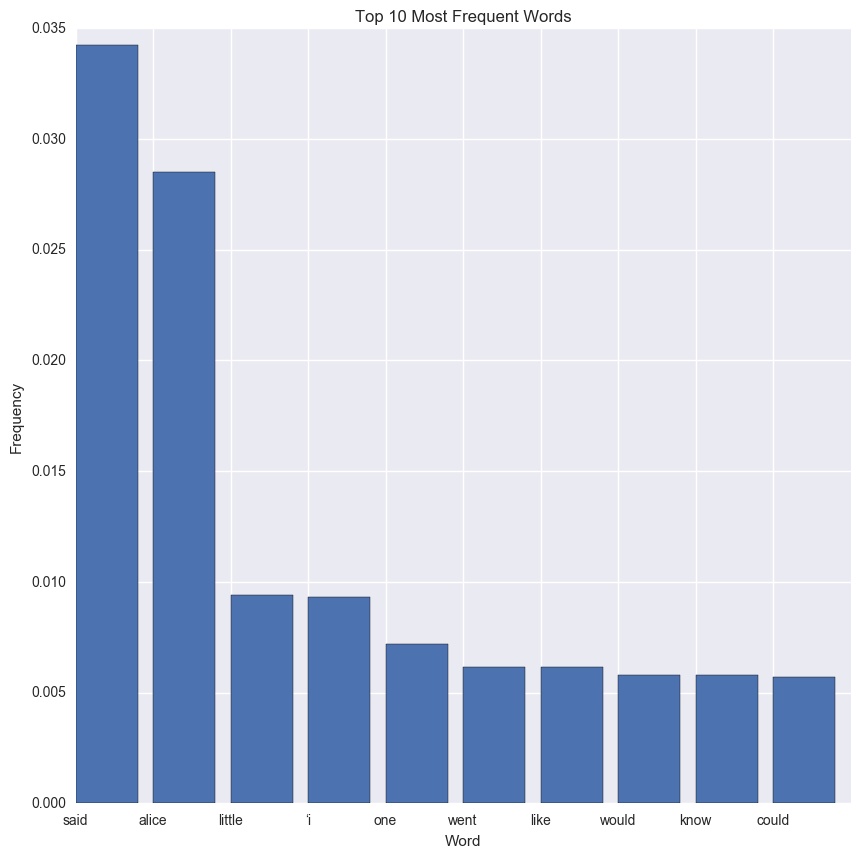

In [252]:
# show the frequencies of words
plt.figure(figsize=(10, 10))
plt.bar(xr, yr, tick_label=lab, )
plt.title('Top 10 Most Frequent Words')
plt.xlabel('Word')
plt.ylabel('Frequency');